In [ ]:
  # ===============================
# UAS ANALISIS BIG DATA
# Tema: Customer Segmentation
# Model Utama: K-Means
# Model Pembanding: Hierarchical Clustering
# Dataset: Online Retail (UCI / Kaggle)
# ===============================

# 1. IMPORT LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [ ]:
# 2. LOAD DATASET
# Pastikan file sudah berada di direktori kerja
# Dataset ini memiliki >500.000 records (memenuhi syarat UAS)
df = pd.read_excel('Online Retail.xlsx')

print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# 3. DATA UNDERSTANDING
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [ ]:
# 4. DATA CLEANING
# Hapus transaksi yang tidak valid
# - Quantity <= 0
# - UnitPrice <= 0
# - CustomerID kosong

df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df = df.dropna(subset=['CustomerID'])

print(df.shape)

(397884, 8)


In [ ]:
# 5. FEATURE ENGINEERING (RFM ANALYSIS)
# RFM = Recency, Frequency, Monetary

# Tambah kolom TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Tanggal referensi
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [ ]:
# 6. SCALING
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

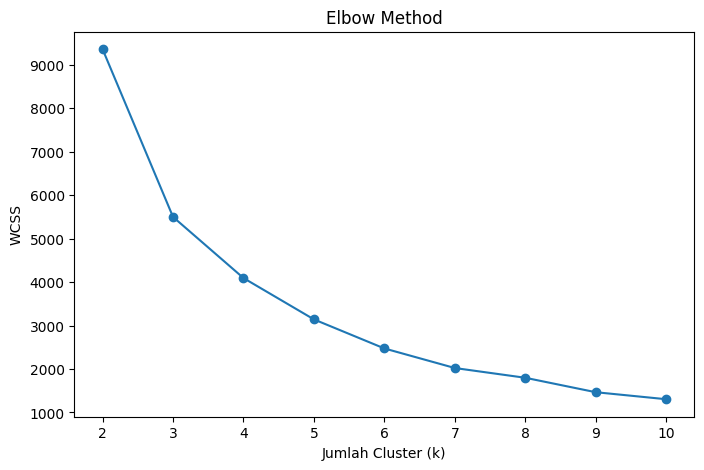

In [ ]:
# 7. MENENTUKAN JUMLAH CLUSTER (ELBOW METHOD)
wcss = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, wcss, marker='o')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [ ]:
# 8. MODEL UTAMA: K-MEANS
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_scaled)

# Evaluasi
sil_kmeans = silhouette_score(rfm_scaled, rfm['Cluster_KMeans'])
print('Silhouette Score K-Means:', sil_kmeans)

Silhouette Score K-Means: 0.616212846765192


In [ ]:
# 9. MODEL PEMBANDING: HIERARCHICAL CLUSTERING
hc = AgglomerativeClustering(n_clusters=4)
rfm['Cluster_HC'] = hc.fit_predict(rfm_scaled)

sil_hc = silhouette_score(rfm_scaled, rfm['Cluster_HC'])
print('Silhouette Score Hierarchical:', sil_hc)

Silhouette Score Hierarchical: 0.6065329601634818


In [ ]:
# 10. CLUSTER PROFILING (K-MEANS)
cluster_profile = rfm.groupby('Cluster_KMeans').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Jumlah Customer'})

cluster_profile

,Recency,Frequency,Monetary,Jumlah Customer
Cluster_KMeans,,,,
0,43.702685,3.682711,1359.049284,3054
1,248.075914,1.552015,480.617480,1067
2,7.384615,82.538462,127338.313846,13
3,15.500000,22.333333,12709.090490,204


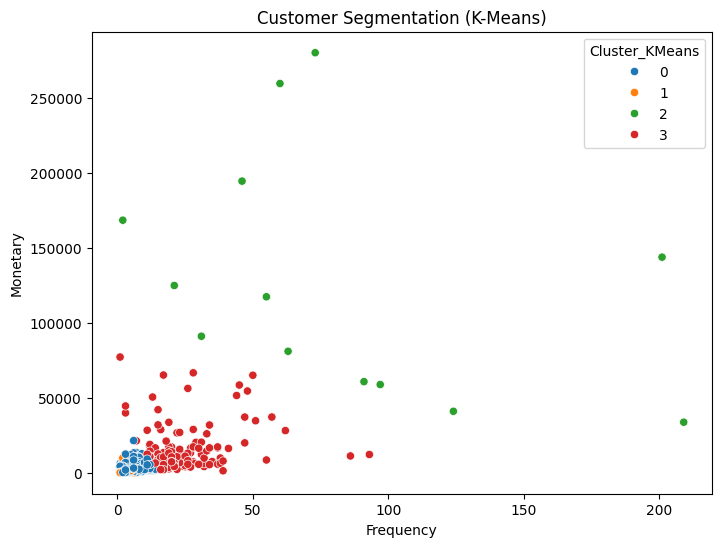

In [ ]:
# 11. VISUALISASI CLUSTER
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=rfm['Frequency'],
    y=rfm['Monetary'],
    hue=rfm['Cluster_KMeans'],
    palette='tab10'
)
plt.title('Customer Segmentation (K-Means)')
plt.show()

In [ ]:
# 12. INTERPRETASI BISNIS
# Cluster dengan Frequency & Monetary tinggi = pelanggan loyal
# Cluster dengan Recency tinggi & Monetary rendah = pelanggan berisiko churn

In [ ]:
# 13. SIMPAN HASIL
rfm.to_csv('customer_segmentation_result.csv', index=False)

print('Analisis Customer Segmentation selesai.')

Analisis Customer Segmentation selesai.


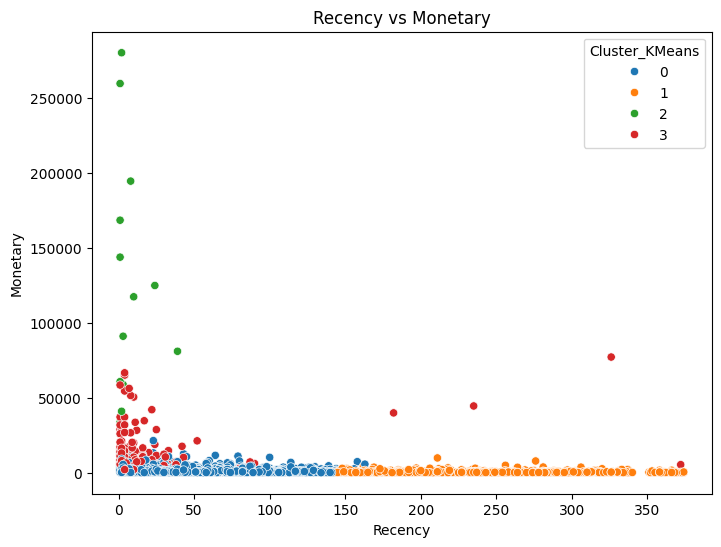

In [ ]:
# 14 Visualisasi Recency
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=rfm['Recency'],
    y=rfm['Monetary'],
    hue=rfm['Cluster_KMeans'],
    palette='tab10'
)
plt.title('Recency vs Monetary')
plt.show()

In [ ]:
# 15 Tabel RFM Profiling
cluster_profile

,Recency,Frequency,Monetary,Jumlah Customer
Cluster_KMeans,,,,
0,43.702685,3.682711,1359.049284,3054
1,248.075914,1.552015,480.617480,1067
2,7.384615,82.538462,127338.313846,13
3,15.500000,22.333333,12709.090490,204


In [ ]:
# 16 Bandingkan beberapa nilai k
for k in [3,4,5]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    print(f'k={k}, Silhouette={silhouette_score(rfm_scaled, labels):.3f}')

k=3, Silhouette=0.585
k=4, Silhouette=0.616
k=5, Silhouette=0.617


In [ ]:
# 17 Simpan hasil centroid
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=['Recency', 'Frequency', 'Monetary']
)
centroids

,Recency,Frequency,Monetary
0,43.855229,3.683007,1358.860191
1,248.564030,1.551789,478.107581
2,1.500000,135.833333,58381.123333
3,15.666667,22.264706,13480.774314
4,7.666667,42.833333,190863.461667
